# **차량 공유업체의 차량 파손 여부 분류하기**

## 0.미션

* 1) 미션1 : Data Preprocessing
    - **과제 수행 목표**
        - 본인의 구글 드라이브에 모델링 수행을 위해 적절한 폴더 및 파일로 **일관성 있게 정리**해야 합니다.
        - 제공된 데이터 : Car_Images.zip
            * Car_Images : 차량의 정상/파손 이미지 무작위 수집

* 2) 미션2 : CNN 모델링
    - **과제 수행 목표**
        - Tensorflow Keras를 이용하여 모델을 3개 이상 생성하세요.
            - 모델 구조와 파라미터는 자유롭게 구성하세요.
            - 단, 세부 목차에서 명시한 부분은 지켜주세요.

* 3) 미션3 : Data Argumentation & Transfer Learning
    - **과제 수행 목표**
        - 성능 개선을 위해 다음의 두가지를 시도하세요.
            * Data Augmentation을 적용하세요.(Image Generator)
            * Transfer Learning(VGG16)


## 1.환경설정 

### (1) 데이터셋 폴더 생성
- **세부요구사항**
    - C드라이브에 Datasets라는 폴더를 만드세요.
        - 구글드라이브를 사용하는경우 드라이브 첫 화면에 Datasets 라는 폴더를 만드세요. ('/content/drive/MyDrive/Datasets/')
    - 해당 폴더 안에 Car_Images.zip 파일을 넣으세요.

* 구글 Colab을 이용하는 경우

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### (2) 데이터셋 불러오기 
- **세부요구사항**
    - Car_Images.zip 파일을 C:/Datasets/ 경로에 압축 해제합니다.
    - zipfile 모듈을 이용하거나 다른 방식을 사용해도 됩니다.
        - 참고 자료 : [zipfile document](https://docs.python.org/3/library/zipfile.html#zipfile-objects)
    - 폴더구조(로컬)
        * C:/Datasets/ : 압축파일
        * C:/Datasets/Car_Images_train/ : 압축 해제한 이미지 저장소
    - 폴더구조(구글드라이브브)
        * /content/drive/MyDrive/Datasets/ : 압축파일
        * /content/drive/MyDrive/Datasets/Car_Images_train/ : 압축 해제한 이미지 저장소
    - 압축을 해제하면 다음과 같은 두 하위 폴더가 생성됩니다.
        * normal, abnormal : 각 폴더에는 이미지들이 있습니다.
        * 이후 단계에서 해당 경로로 부터 validation, test 셋을 추출하게 됩니다.
        

In [2]:
import zipfile
import os

In [3]:
# 압축파일 경로
# 구글 드라이브인 경우 경로에 맞게 지정하세요.
dataset_path  = '/content/drive/MyDrive/Datasets/'

file_path = dataset_path + 'Car_Images.zip'

In [4]:
# 폴더 만들기
mkdir_path = dataset_path + 'Car_Images_train/'
# 만든 폴더에 압축 해제
zipfile.ZipFile(file_path).extractall(mkdir_path)

### (3) 이미지 저장을 위한 폴더 생성
- **세부요구사항**
    - train, validation, test 을 위해 각각 하위 폴더 normal과 abnormal를 준비합니다.
        - train
            * 정상 이미지 저장소 : C:/Datasets/Car_Images_train/normal/ 
                * 구글드라이브 :   /content/drive/MyDrive/Datasets/Car_Images_train/normal/
            * 파손 이미지 저장소 : C:/Datasets/Car_Images_train/abnormal/
                * 구글드라이브 : /content/drive/MyDrive/Datasets/Car_Images_train/abnormal/
        - val, test 역시 동일한 구조로 생성합니다.
    - 직접 탐색기에서 폴더를 생성할 수도 있고, os 모듈을 이용하여 코드로 작성할 수도 있습니다.
        - 참고 자료 : [os document](https://docs.python.org/3/library/os.html)

In [5]:
# 파일 갯수 확인
len(os.listdir((dataset_path + 'Car_Images_train/normal/'))), len(os.listdir((dataset_path + 'Car_Images_train/abnormal/')))

(302, 303)

In [6]:
# test 폴더 만들기 os.mkdir()
path = dataset_path + 'Car_Images_test/'
os.makedirs(path, exist_ok = True)


# validation 폴더 만들기
path = dataset_path + 'Car_Images_val/'
os.makedirs(path, exist_ok = True)

## 2.데이터 전처리

### (1) 데이터 분할 : Training set | Validation set | Test set 생성
- **세부요구사항**
    - Training set, Validation set, Test set을 만듭니다.
        * size
            * test : 전체에서 20%를 추출합니다.
            * validation : test를 떼어낸 나머지에서 다시 20%를 추출합니다.
        * 데이터는 랜덤하게 추출해야 합니다.
            - random, shutil 모듈을 이용하여 랜덤하게 추출할 수 있습니다.
                - [random document](https://docs.python.org/3/library/random.html) | [shutil document](https://docs.python.org/3/library/shutil.html)
            * 해당 모듈 이외에 자신이 잘 알고 있는 방법을 사용해도 됩니다.
---

#### 1) test, validation 크기를 지정

In [7]:
import random, shutil

In [8]:
tr_n_path = mkdir_path + 'normal/'
tr_ab_path = mkdir_path + 'abnormal/'

In [9]:
# 전체 이미지 갯수를 확인합니다.
len(os.listdir(tr_n_path)) , len(os.listdir(tr_ab_path))

(302, 303)

In [10]:
# test 사이즈 : 전체 이미지의 20%
te_data_num = [round(len(os.listdir(tr_n_path))*0.2), round(len(os.listdir(tr_ab_path))*0.2)]
print(te_data_num)

# validation 사이즈 : test를 제외한 나머지 중에서 20%
val_data_num = [ round((len(os.listdir(tr_n_path))-te_data_num[0])*0.2) , round((len(os.listdir(tr_n_path))-te_data_num[1])*0.2) ]
print(val_data_num)

# train 사이즈
train_data_num = [len(os.listdir(tr_n_path)) - te_data_num[0] - val_data_num[0],
                  len(os.listdir(tr_ab_path))- te_data_num[1] - val_data_num[1]]
print(train_data_num)

[60, 61]
[48, 48]
[194, 194]


#### 2) test 셋 추출

In [11]:
from tensorflow.keras.utils import load_img

In [12]:
# 나뉘기 전 (현재의 train) 데이터와 해당 데이터 경로 가져오기
n_img_path_list = os.listdir(tr_n_path)
ab_img_path_list = os.listdir(tr_ab_path)

In [13]:
n_img_path_list[:5]

['DALLíñE 2023-03-10 18.50.18 - photo of a part of car.png',
 'DALLíñE 2023-03-10 18.52.35 - photo of a part of car.png',
 'DALLíñE 2023-03-10 18.52.17 - photo of a part of car.png',
 'DALLíñE 2023-03-10 18.50.11 - photo of a part of car.png',
 'DALLíñE 2023-03-10 18.52.13 - photo of a part of car.png']

In [14]:
# 섞기
random.seed(2023)
random.shuffle(n_img_path_list)
random.shuffle(ab_img_path_list)

In [15]:
n_img_path_list[:5]

['DALLíñE 2023-03-11 14.32.58 - part of a car.png',
 'DALLíñE 2023-03-11 01.14.11 - a part of a car.png',
 'DALLíñE 2023-03-11 00.51.42 - photo of a part of car.png',
 'DALLíñE 2023-03-11 14.26.19 - part of a car.png',
 'DALLíñE 2023-03-11 00.52.58 - photo of a part of car.png']

In [16]:
# 추출 후 이미지 갯수 확인
te_data_num

# test data 갯수만큼 test로 분리
test_n_path = n_img_path_list[:te_data_num[0]]
test_ab_path = ab_img_path_list[:te_data_num[1]]

# 나머지는 train
train_n_path = n_img_path_list[te_data_num[0]:]
train_ab_path = ab_img_path_list[te_data_num[1]:]

#### 3) validation 셋 추출

- val_data 슬라이싱, train_data 슬라이싱

In [17]:
# train data에서 val data 개수만큼 val로 분리
val_n_path = train_n_path[:val_data_num[0]]
val_ab_path = train_ab_path[:val_data_num[1]]

# 나머지는 train
train_n_path = train_n_path[val_data_num[0]:]
train_ab_path = train_ab_path[val_data_num[1]:]

In [18]:
# 추출 후 이미지 갯수 확인
len(train_n_path), len(train_ab_path), len(test_n_path), len(test_ab_path), len(val_n_path), len(val_ab_path)

(194, 194, 60, 61, 48, 48)

### (2) 데이터 복사 및 이동
- **세부요구사항**
    - 분할된 데이터를 복사 이동합니다.
        - 새로운 폴더에 저장하는 데이터로 "3.모델링I"에서 사용합니다.
        - 기존 폴더는 "4.모델링II > (1) Data Augmentation"에서 사용합니다.
    - Training set | Validation set | Test set의 데이터를 **새로운 폴더**에 복사하세요.
        - 새로운 폴더 명
            * copy_images/trainset
            * copy_images/validset
            * copy_images/testset
        - 새로운 폴더에는 normal, abnormal 파일 모두를 복사합니다. 
            * 파일을 구분하기 위해 abnormal 파일들은 파일명 앞에 접두사 'ab_'를 붙입시다.
        - os, shutil 모듈을 활용하세요.

#### 1) abnormal 파일 복사

* 복사하기 : shutil.copytree()

In [19]:
# Training set | Validation set | Test set의 데이터를 새로운 폴더에 복사
os.makedirs(dataset_path+'copy_images/trainset', exist_ok = True)
os.makedirs(dataset_path+'copy_images/validset', exist_ok = True)
os.makedirs(dataset_path+'copy_images/testset', exist_ok = True)

* abnormal 이미지 이름의 접두어 "ab_" 붙이기 : os.rename

In [20]:
def copyfile_splited(filenames, src, dest):
    bin_class = src.split('/')[-2]
    for filename in filenames:
        if 'ab' in bin_class: # ab_ 구분 처리
            shutil.copy(src + filename, dest + 'ab_' + filename)
        else : 
            shutil.copy(src + filename, dest + filename)

In [21]:
copyfile_splited(train_n_path, dataset_path + 'Car_Images_train/normal/', dataset_path + 'copy_images/trainset/')
copyfile_splited(train_ab_path, dataset_path + 'Car_Images_train/abnormal/', dataset_path + 'copy_images/trainset/')

copyfile_splited(test_n_path, dataset_path + 'Car_Images_train/normal/', dataset_path + 'copy_images/testset/')
copyfile_splited(test_ab_path, dataset_path + 'Car_Images_train/abnormal/', dataset_path + 'copy_images/testset/')

copyfile_splited(val_n_path, dataset_path + 'Car_Images_train/normal/', dataset_path + 'copy_images/validset/')
copyfile_splited(val_ab_path, dataset_path + 'Car_Images_train/abnormal/', dataset_path + 'copy_images/validset/')

In [22]:
len(os.listdir('/content/drive/MyDrive/Datasets/copy_images/testset')), len(os.listdir('/content/drive/MyDrive/Datasets/copy_images/trainset')), len(os.listdir('/content/drive/MyDrive/Datasets/copy_images/validset')),

(184, 479, 149)

#### 2) normal 파일 복사

* 데이터 갯수 조회

In [23]:
print(len(os.listdir(dataset_path+'copy_images/trainset/')))
print(len(os.listdir(dataset_path+'copy_images/validset/')))
print(len(os.listdir(dataset_path+'copy_images/testset/')))

479
149
184


## 3.모델링 I
* **세부요구사항**
    * 모델링을 위한 데이터 구조 만들기
        * x : 이미지를 array로 변환합니다.
        * y : 이미지 갯수만큼 normal - 0, abnormal - 1 로 array를 만듭니다.
    * 모델을 최소 3개 이상 만들고 성능을 비교합니다.
        * 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
        * 전처리 과정에서 생성한 Validation set을 적절하게 사용하세요.
        * Early Stopping을 반드시 사용하세요.
            * 최적의 가중치를 모델에 적용하세요.

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

### (1) X : image to array
- **세부요구사항**
    * 모델링을 위해서는 np.array 형태로 데이터셋을 만들어야 합니다.
    * Training set / Validation set / Test set의 X는 이미지 형태로 되어있습니다. 
    * 이미지 파일을 불러와 train, valid, test 각각 array 형태로 변환해 봅시다.
        * 각 폴더로 부터 이미지 목록을 만들고
        * 이미지 한장씩 적절한 크기로 로딩하여 (keras.utils.load_img)
            * 이미지가 너무 크면 학습시간이 많이 걸리고, 메모리 부족현상이 발생될 수 있습니다.
            * 이미지 크기를 280 * 280 * 3 이내의 크기를 설정하여 로딩하시오.
            * array로 변환 (keras.utils.img_to_array, np.expand_dims)
        * 데이터셋에 추가합니다.(데이터셋도 array)

#### 1) 이미지 목록 만들기
* train, validation, test 폴더로 부터 이미지 목록을 생성합니다.

In [25]:
from tensorflow.keras.utils import load_img, img_to_array

In [26]:
# 이미지 목록 저장
img_train_list = os.listdir(dataset_path+'copy_images/trainset/')
img_valid_list = os.listdir(dataset_path+'copy_images/validset/')
img_test_list = os.listdir(dataset_path+'copy_images/testset/')

In [27]:
# 메모리, 처리시간을 위해서 이미지 크기 조정
img_size = 280 ## 사이즈 조정 가능

#### 2) 이미지들을 배열 데이터셋으로 만들기

In [28]:
# 이미지를 배열 데이터셋으로 만드는 함수
def make_img_to_array(path, img_list, img_size):
    temp_x = []
    img_arr_x = []
    # x 데이터 갯수만큼 abnormal : 0, normal : 1
    temp_y = [1] * len(img_list)

    # 각 이미지 별 데이터 만들기
    for idx, img_name in enumerate(img_list):
        temp_x.append(load_img(path + img_name, target_size = (img_size, img_size)))

        # abnormal은 0
        if 'ab' == img_name[:2]:
            temp_y[idx] = 0

    # img를 array로 변환
    for img in temp_x:
        img_arr_x.append(img_to_array(img))

    return [np.array(img_arr_x), np.array(temp_y)]

In [29]:
train_x, train_y = make_img_to_array(dataset_path + 'copy_images/trainset/', img_train_list, img_size)
test_x, test_y = make_img_to_array(dataset_path + 'copy_images/testset/', img_test_list, img_size)
val_x, val_y = make_img_to_array(dataset_path + 'copy_images/validset/', img_valid_list, img_size)

In [30]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((479, 280, 280, 3),
 (479,),
 (184, 280, 280, 3),
 (184,),
 (149, 280, 280, 3),
 (149,))

### (2) y : 클래스 만들기
- **세부요구사항**
    - Training set / Validation set / Test set의 y를 생성합니다.
        - 각각 normal, abnormal 데이터의 갯수를 다시 확인하고
        - normal을 0, abnormal을 1로 지정합니다.

In [31]:
# 데이터 갯수 확인
print( len(img_train_list) )
print( len([val for val in img_train_list if val.startswith('ab_')]) )
print('---')
print( len(img_valid_list) )
print( len([val for val in img_valid_list if val.startswith('ab_')]) )
print('---')
print( len(img_test_list) )
print( len([val for val in img_test_list if val.startswith('ab_')]) )

479
243
---
149
76
---
184
97


* y_train, y_valid, y_test 만들기
    * normal, abnormal 데이터의 갯수를 다시 확인하고 normal을 0, abnormal을 1로 지정합니다.

In [32]:
print('전체 train 개수 :',len(train_y), 'normal 개수 : ', len([val for val in img_train_list if val.startswith('n')]), ' abnormal 개수 : ', len([val for val in img_train_list if val.startswith('ab')]))
print('전체 valid 개수 :',len(val_y), 'normal 개수 : ', len([val for val in img_valid_list if val.startswith('n')]), ' abnormal 개수 : ', len([val for val in img_valid_list if val.startswith('ab')]))
print('전체 test 개수 :',len(test_y), 'normal 개수 : ', len([val for val in img_test_list if val.startswith('n')]), ' abnormal 개수 : ', len([val for val in img_test_list if val.startswith('ab')]))



전체 train 개수 : 479 normal 개수 :  0  abnormal 개수 :  243
전체 valid 개수 : 149 normal 개수 :  0  abnormal 개수 :  76
전체 test 개수 : 184 normal 개수 :  0  abnormal 개수 :  97


In [33]:
img_valid_list

['DALLíñE 2023-03-11 14.16.12 - part of a car.png',
 'DALLíñE 2023-03-11 01.18.07 - a part of a car.png',
 'DALLíñE 2023-03-10 23.56.41 - a part of car without blemish.png',
 'DALLíñE 2023-03-11 14.35.20 - part of a car.png',
 'DALLíñE 2023-03-11 17.08.39 - a part of a car.png',
 'DALLíñE 2023-03-11 14.37.15 - photo of part of a car.png',
 'DALLíñE 2023-03-11 14.41.14 - photo of part of a car.png',
 'DALLíñE 2023-03-11 14.25.21 - part of a car.png',
 'DALLíñE 2023-03-11 01.18.02 - a part of a car.png',
 'ab_DALLíñE 2023-03-11 17.27.04 - slightly dented car.png',
 'ab_DALLíñE 2023-03-11 14.55.32 - dents of a car.png',
 'ab_DALLíñE 2023-03-10 23.44.25 - photo of a part of car without blemish.png',
 'ab_DALLíñE 2023-03-11 18.41.54 - slightly dented car.png',
 'ab_DALLíñE 2023-03-10 23.28.30 - photo of a part of car without blemish.png',
 'ab_DALLíñE 2023-03-11 15.08.28 - dents of a car.png',
 'ab_DALLíñE 2023-03-11 14.49.32 - dents of a car.png',
 'ab_DALLi

### (3) 모델1
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

### X : 표준화 Scaling (standardization)

$$ X_{scaled} = {{x_{original} - mean(x)}\over{std(x)} } $$

In [34]:
train_x.max(), train_x.min()

(255.0, 0.0)

In [35]:
# max_n, min_n = train_x.max(), train_x.min()

# train_x = (train_x - min_n)/(max_n - min_n)
# test_x = (test_x - min_n)/(max_n - min_n)
# val_x = (val_x - min_n)/(max_n - min_n)

In [36]:
mean_n = train_x.mean()
std_n = train_x.std()

train_x = (train_x - mean_n) / std_n
test_x = (test_x - mean_n) / std_n
val_x = (val_x - mean_n) / std_n

In [37]:
train_x.max(), train_x.min(), test_x.max(), test_x.min(), val_x.max(), val_x.min()

(1.9444648, -1.9512455, 1.9444648, -1.9512455, 1.9444648, -1.9512455)

In [38]:
from tensorflow.keras.utils import to_categorical

class_n = len(np.unique(train_y))

In [39]:
train_y = to_categorical(train_y, class_n)
test_y = to_categorical(test_y, class_n)
val_y = to_categorical(val_y, class_n)

In [40]:
train_y.shape, test_y.shape, val_y.shape

((479, 2), (184, 2), (149, 2))

#### 1) 구조 설계

In [41]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model

In [46]:
# 1. 세션 클리어
clear_session()
# 2. 모델 사슬처럼 잇기
il = Input(shape = (img_size, img_size, 3))

hl = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(il)
hl = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
hl = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
hl = BatchNormalization()(hl)
hl = MaxPool2D(pool_size= (2, 2), strides = (2, 2))(hl)

hl = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
hl = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
hl = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
hl = BatchNormalization()(hl)
hl = MaxPool2D(pool_size= (2, 2), strides = (2, 2))(hl)

hl = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
hl = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
hl = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
hl = BatchNormalization()(hl)
hl = MaxPool2D(pool_size= (2, 2), strides = (2, 2))(hl)

hl = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
hl = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
hl = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
hl = BatchNormalization()(hl)
hl = MaxPool2D(pool_size= (2, 2), strides = (2, 2))(hl)

hl = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
hl = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
hl = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
hl = BatchNormalization()(hl)
hl = MaxPool2D(pool_size= (2, 2), strides = (2, 2))(hl)

hl = Flatten()(hl)
hl = Dense(64, activation = 'relu')(hl)

hl = BatchNormalization()(hl)
hl = Dropout(0.35)(hl)

ol = Dense(2, activation = 'sigmoid')(hl)
# 3. 처음과 끝 지정
model = Model(il, ol)
# 4. 컴파일
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = 'adam')
# 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 280, 280, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 280, 280, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 280, 280, 128)     147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 280, 280, 128)     147584    
                                                                 
 batch_normalization (BatchN  (None, 280, 280, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 140, 140, 128)    0         
 )                                                           

#### 2) 학습
* EarlyStopping 설정하고 학습시키기

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

In [44]:
es = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 15, verbose = 1, restore_best_weights = True)

In [47]:
model.fit(train_x, train_y, epochs = 1000, validation_data = (val_x, val_y), verbose = 1, callbacks = [es])

Epoch 1/1000
15/15 [==============================] - 23s 669ms/step - loss: 0.5751 - accuracy: 0.7871 - val_loss: 1989.7305 - val_accuracy: 0.4899
Epoch 2/1000
15/15 [==============================] - 4s 265ms/step - loss: 0.4476 - accuracy: 0.8372 - val_loss: 256.0161 - val_accuracy: 0.4966
Epoch 3/1000
15/15 [==============================] - 4s 265ms/step - loss: 0.3993 - accuracy: 0.8455 - val_loss: 49.7497 - val_accuracy: 0.5034
Epoch 4/1000
15/15 [==============================] - 4s 265ms/step - loss: 0.3804 - accuracy: 0.8580 - val_loss: 11.7182 - val_accuracy: 0.5705
Epoch 5/1000
15/15 [==============================] - 4s 265ms/step - loss: 0.3050 - accuracy: 0.8894 - val_loss: 3.8283 - val_accuracy: 0.6644
Epoch 6/1000
15/15 [==============================] - 4s 267ms/step - loss: 0.2669 - accuracy: 0.8977 - val_loss: 2.6866 - val_accuracy: 0.7383
Epoch 7/1000
15/15 [==============================] - 4s 265ms/step - loss: 0.2903 - accuracy: 0.8935 - val_loss: 1.9454 - val_a

#### 3) test set으로 예측하고 평가하기
* 평가는 confusion_matrix, classification_report 활용

In [48]:
from sklearn.metrics import confusion_matrix, classification_report

In [49]:
y_pred = model.predict(test_x)
y_pred.shape

6/6 [==============================] - 2s 294ms/step


(184, 2)

In [50]:
single_y_pred = y_pred.argmax(axis = 1)
single_y_pred.shape

(184,)

In [51]:
print(test_y.shape)
single_test_y = test_y.argmax(axis=1)
print(single_test_y.shape)

(184, 2)
(184,)


In [52]:
print(confusion_matrix(single_test_y, single_y_pred))
print(classification_report(single_test_y, single_y_pred))

[[90  7]
 [ 8 79]]
              precision    recall  f1-score   support

           0       0.92      0.93      0.92        97
           1       0.92      0.91      0.91        87

    accuracy                           0.92       184
   macro avg       0.92      0.92      0.92       184
weighted avg       0.92      0.92      0.92       184



In [58]:
model.save(dataset_path + '92model.h5')

In [59]:
from tensorflow.keras.models import load_model
model = load_model(dataset_path + '92model.h5')

### 3-1) loss, acc 시각화하기

Epoch 1/1000
15/15 [==============================] - 4s 276ms/step - loss: 0.0084 - accuracy: 1.0000 - val_loss: 0.2923 - val_accuracy: 0.9128
Epoch 2/1000
15/15 [==============================] - 4s 261ms/step - loss: 0.0174 - accuracy: 0.9979 - val_loss: 0.3132 - val_accuracy: 0.9262
Epoch 3/1000
15/15 [==============================] - 4s 262ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.5331 - val_accuracy: 0.8993
Epoch 4/1000
15/15 [==============================] - 4s 263ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.3731 - val_accuracy: 0.8926
Epoch 5/1000
15/15 [==============================] - 4s 262ms/step - loss: 0.0242 - accuracy: 0.9937 - val_loss: 0.8449 - val_accuracy: 0.8859
Epoch 6/1000
15/15 [==============================] - 4s 262ms/step - loss: 0.0289 - accuracy: 0.9958 - val_loss: 0.8232 - val_accuracy: 0.8993
Epoch 7/1000
15/15 [==============================] - 4s 262ms/step - loss: 0.0334 - accuracy: 0.9875 - val_loss: 1.3026 - val_accuracy:

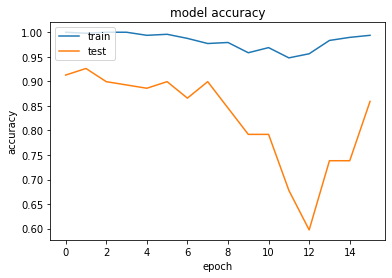

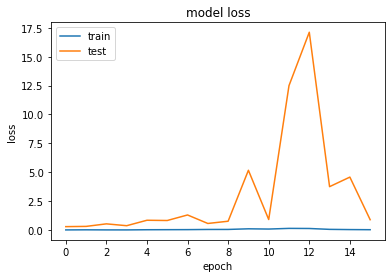

NameError: ignored

In [56]:
import matplotlib.pyplot as plt
# Fit the model
results = model.fit(train_x, train_y, epochs = 1000, validation_data = (val_x, val_y), verbose = 1, callbacks = [es])
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### (4) 모델2
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

#### 1) 구조 설계

In [ ]:
# clear_session()

# il = Input(shape = (img_size, img_size, 3))

# hl = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(il)
# hl = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
# hl = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
# hl = BatchNormalization()(hl)
# hl = MaxPool2D(pool_size= (2, 2), strides = (2, 2))(hl)

# hl = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
# hl = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
# hl = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
# hl = BatchNormalization()(hl)
# hl = MaxPool2D(pool_size= (2, 2), strides = (2, 2))(hl)

# hl = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
# hl = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
# hl = Conv2D(filters = 512, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
# hl = BatchNormalization()(hl)
# hl = MaxPool2D(pool_size= (2, 2), strides = (2, 2))(hl)

# hl = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
# hl = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
# hl = Conv2D(filters = 256, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
# hl = BatchNormalization()(hl)
# hl = MaxPool2D(pool_size= (2, 2), strides = (2, 2))(hl)

# hl = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
# hl = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
# hl = Conv2D(filters = 128, kernel_size = (3, 3), strides = (1, 1), padding = 'same', activation = 'relu')(hl)
# hl = BatchNormalization()(hl)
# hl = MaxPool2D(pool_size= (2, 2), strides = (2, 2))(hl)

# hl = Flatten()(hl)
# hl = Dense(64, activation = 'relu')(hl)

# hl = BatchNormalization()(hl)
# hl = Dropout(0.35)(hl)

# ol = Dense(2, activation = 'sigmoid')(hl)

# model = Model(il, ol)

# model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

# model.summary()

#### 2) 학습
* EarlyStopping 설정하고 학습시키기

#### 3) test set으로 예측하고 평가하기
* 평가는 confusion_matrix, classification_report 활용

### (5) 모델3
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 validation_data로 validation set을 사용하시오.
    - 반드시 Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

#### 1) 구조 설계

#### 2) 학습
* EarlyStopping 설정하고 학습시키기

#### 3) test set으로 예측하고 평가하기
* 평가는 confusion_matrix, classification_report 활용

## 4.모델링 II
* **세부요구사항**
    - 성능을 높이기 위해서 다음의 두가지를 시도해 봅시다.
        - Data Augmentation을 통해 데이터를 증가 시킵니다.
            - ImageDataGenerator를 사용합니다.
        - 사전 학습된 모델(Transfer Learning)을 가져다 사용해 봅시다.
            - VGG16(이미지넷)을 사용해 봅시다.

### (1) Data Augmentation
- **세부요구사항**
    * 모델 학습에 이용할 이미지 데이터를 증강시키세요.
    * Keras의 ImageDataGenerator를 이용
        - [ImageDataGenerator document](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

    * image generator를 이용하여 학습
        * 모델 구조는 이미 생성한 1,2,3 중 하나를 선택하여 학습


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
img_size = 280 ## 사이즈 조정 가능

train_path = dataset_path+'Car_Images_train/'
valid_path = dataset_path+'Car_Images_valid/'

#### 1) ImageGenerator 생성
* ImageDataGenerator 함수 사용
    * 주요 옵션
        * rotation_range: 무작위 회전을 적용할 각도 범위
        * zoom_range: 무작위 줌을 적용할 범위 [1-zoom_range, 1+zoom_range]
        * horizontal_flip: 무작위 좌우반전을 적용할지 여부
        * vertical_flip: 무작위 상하반전을 적용할지 여부
        * rescale: 텐서의 모든 값을 rescale 값으로 나누어줌 (이 경우에는 255로 나누어서 0~1사이의 값으로 변경)

In [ ]:
train_datagen = 

valid_datagen = 


#### 2) 경로로 부터 이미지 불러 올 준비
* .flow_from_directory 이용
    * 디렉토리에서 이미지를 가져와서 데이터 증강을 적용하고 batch 단위로 제공하는 generator를 생성합니다.
    * 이미지를 불러올 때 target_size로 크기를 맞추고, 
    * class_mode로 이진 분류(binary)를 수행하도록 지정합니다.


In [ ]:
train_generator = 

valid_generator = 


#### 3) 학습
- **세부요구사항**
    - Conv2D, MaxPooling2D, Flatten, Dense 레이어들을 이용하여 모델을 설계
    - 학습시 train_generator 이용. 
    - validation_data = valid_generator 지정
    - Early Stopping 적용
    - 평가시, confusion matrix, accuracy, recall, precision, f1 score 등을 이용하시오.

* 구조 설계

* 학습
    * EarlyStopping 설정하기
    * 학습 데이터에 train_generator, validation_data=valid_generator 사용

#### 4) 성능 평가
* 평가는 confusion_matrix, classification_report 활용

### (2) Transfer Learning
- **세부요구사항**
    * VGG16 모델은 1000개의 클래스를 분류하는 데 사용된 ImageNet 데이터셋을 기반으로 사전 학습된 가중치를 가지고 있습니다. 
        * 따라서 이 모델은 이미지 분류 문제에 대한 높은 성능을 보입니다.
        * 이 모델은 보통 전이학습(transfer learning)에서 기본적으로 사용되며, 특히 대규모 데이터셋이 없을 때는 기본 모델로 사용되어 fine-tuning을 수행합니다.
    * VGG16 함수로 부터 base_model 저장


In [ ]:
from tensorflow.keras.applications import VGG16

#### 1) VGG16 불러와서 저장하기
* include_top=False로 설정하여 분류기를 제외하고 미리 학습된 가중치 imagenet을 로드합니다.
* .trainable을 True로 설정하여 모델의 모든 레이어들이 fine-tuning에 대해 업데이트되도록 합니다.


In [ ]:
base_model = VGG16(                 )




#### 2) VGG16과 연결한 구조 설계
* VGG16을 불러와서 Flatten, Dense 등으로 레이어 연결하기

#### 3) 학습
- **세부요구사항**
    - 모델 학습 과정에 알맞은 보조 지표를 사용하세요.
    - 데이터
        * Image Generator를 연결하거나
        * 기존 train, validation 셋을 이용해도 됩니다.
        - Early Stopping을 반드시 사용하세요.
        - 최적의 가중치를 모델에 적용하세요.

#### 4) 성능 평가